In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
airlines=pd.read_csv("/content/Airlines+Data.csv")

In [3]:
airlines

,Month,Passengers
0,Jan-95,112
1,Feb-95,118
2,Mar-95,132
3,Apr-95,129
4,May-95,121
...,...,...
91,Aug-02,405
92,Sep-02,355
93,Oct-02,306
94,Nov-02,271


In [4]:
airlines.index = pd.to_datetime(airlines.Month,format="%b-%y")


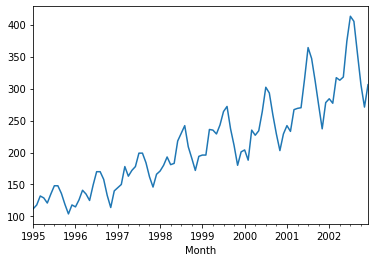

In [5]:
airlines.Passengers.plot() # time series plot 

In [6]:
# Creating a Date column to store the actual Date format for the given Month column
airlines["Date"] = pd.to_datetime(airlines.Month,format="%b-%y")


In [7]:
airlines["month"] = airlines.Date.dt.strftime("%b") # month extraction

In [8]:
airlines["Day"] = airlines.Date.dt.strftime("%d") # Day extraction
airlines["wkday"] = airlines.Date.dt.strftime("%A") # weekday extraction
airlines["year"] = airlines.Date.dt.strftime("%Y") # year extraction


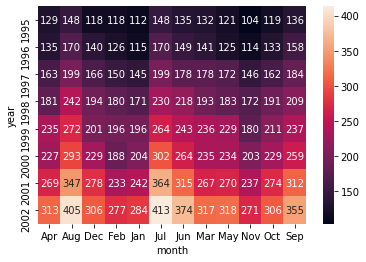

In [9]:
# Some EDA on Time series data 
# Heat map visualization 
heatmap_y_month = pd.pivot_table(data=airlines,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")


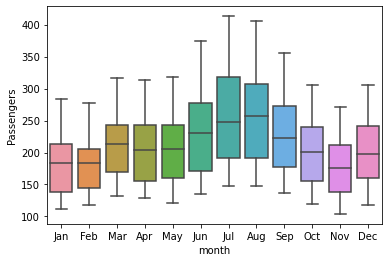

In [10]:
# Boxplot for ever
sns.boxplot(x="month",y="Passengers",data=airlines)

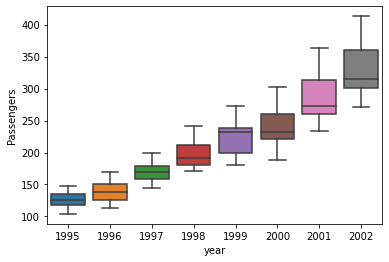

In [11]:
sns.boxplot(x="year",y="Passengers",data=airlines)

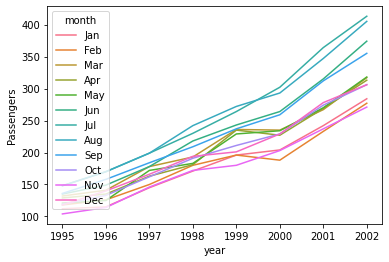

In [12]:
# Line plot for Ridership based on year  and for each month
sns.lineplot(x="year",y="Passengers",hue="month",data=airlines)


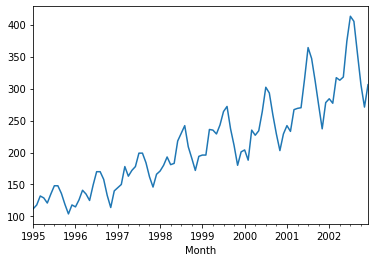

In [13]:
# moving average for the time series to understand better about the trend character in airlines
airlines.Passengers.plot(label="org")

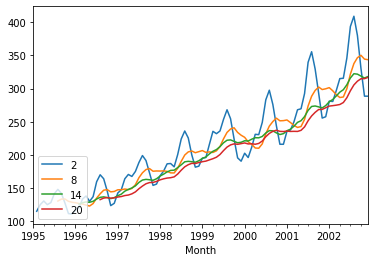

In [14]:
for i in range(2,24,6):
    airlines["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

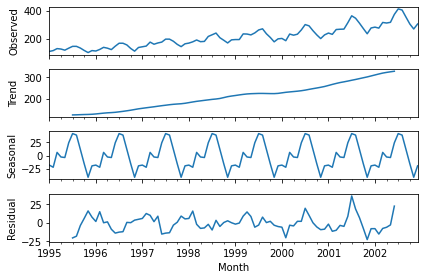

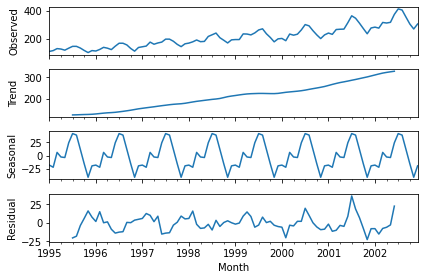

In [15]:
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(airlines.Passengers,model="additive")
decompose_ts_add.plot()

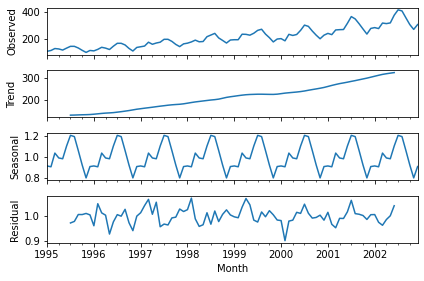

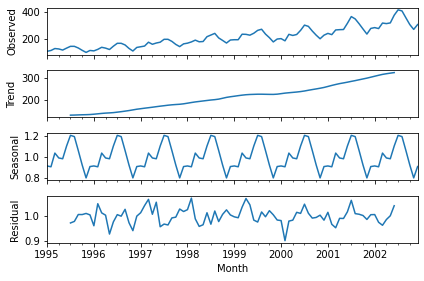

In [16]:
decompose_ts_mul = seasonal_decompose(airlines.Passengers,model="multiplicative")
decompose_ts_mul.plot()


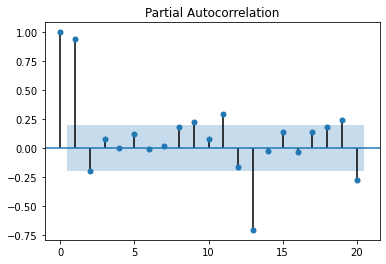

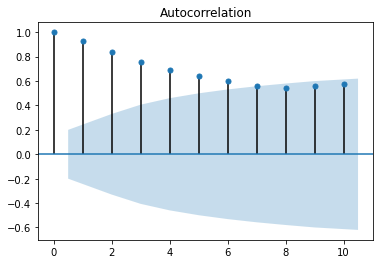

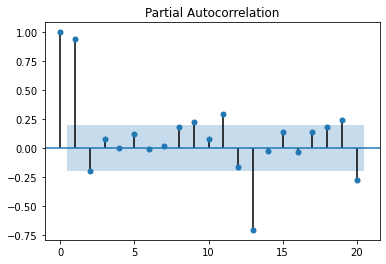

In [19]:
# ACF plots and PACF plots on Original data sets 
tsa_plots.plot_acf(airlines.Passengers,lags=10)
tsa_plots.plot_pacf(airlines.Passengers)


In [20]:
Train = airlines.head(88)
Test = airlines.tail(8)

In [21]:
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

In [22]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(airlines["Passengers"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


10.301826697174459

In [23]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


13.009720271975874

In [24]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2.1380872742796737

In [25]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


4.026304766657528

In [28]:
# Lets us use auto_arima from p
from pmdarima import auto_arima
auto_arima_model = auto_arima(Train["Passengers"],start_p=0,
                              start_q=0,max_p=10,max_q=10,
                              m=12,start_P=0,seasonal=True,
                              d=1,D=1,trace=True,error_action="ignore",
                              suppress_warnings= True,
                              stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=563.391, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=559.217, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=560.932, Time=0.38 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=559.298, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=561.053, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=560.846, Time=0.19 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=560.069, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=557.292, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=558.347, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=556.779, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=558.779, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(0,1,1)(2,1,0)[12]  

In [27]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 15.0MB/s 
     |████████████████████████████████| 9.5MB 52.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [29]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   88
Model:             SARIMAX(0, 1, 3)x(1, 1, 0, 12)   Log Likelihood                -273.075
Date:                            Tue, 08 Jun 2021   AIC                            556.150
Time:                                    16:48:21   BIC                            567.737
Sample:                                         0   HQIC                           560.777
                                             - 88                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2801      0.118     -2.374      0.018      -0.511      -0.049
ma.L2          0.0541      0.141      0.385      0.700      -0.221       0.330
ma.L3         -0.2522      0.139     -1.812      0.070      -0.525       0.021
ar.S.L12      -0.2514      0.115     -2.190      0.029      -0.476      -0.026
sigma2        83.9126     14.157      5.927      0.000      56.166     111.659
===================================================================================
Ljung-Box (Q):                       23.87   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.98   Prob(JB):                         0.44
Heteroskedasticity (H):               2.14   Skew:                             0.36
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# For getting Fitted values for train data set we use 
# predict_in_sample() function 
auto_arima_model.predict_in_sample( )


array([  0.        , 111.99845051, 118.00045979, 131.99841474,
       129.00010383, 120.99987161, 134.99959098, 147.99997746,
       147.99982904, 136.00035643, 119.00021299, 104.00094837,
       174.00129249, 121.00364459, 138.65017746, 137.93796737,
       126.76454886, 138.76247561, 159.76039204, 168.16236801,
       155.4780954 , 137.82404994, 119.41876479, 128.73354113,
       135.07584912, 153.98095235, 163.70375757, 166.18289964,
       156.15798445, 185.28965764, 200.69217046, 195.08844871,
       187.6508001 , 162.67256696, 143.01018985, 169.02945436,
       170.16838835, 176.35778652, 204.52000659, 183.4771703 ,
       184.37417541, 196.68214859, 233.57931292, 232.50305253,
       219.52437127, 190.61022297, 171.17173614, 195.95196133,
       199.49327071, 204.65810687, 215.50001399, 217.91601046,
       237.2681853 , 254.77868091, 255.80619931, 272.13513842,
       246.97796542, 218.71525797, 194.40932191, 207.63180616,
       206.77762176, 210.31596994, 228.98358017, 229.04

In [31]:
# For getting predictions for future we use predict() function 
pred_test = pd.Series(auto_arima_model.predict(n_periods=12))

In [34]:
combinations_l = list((range(1,7),range(2),range(1,7)))
combinations_u = list((range(1,7),range(2),range(1,7)))
m =12 

In [35]:
results_sarima = []
best_aic = float("inf")

In [36]:
for i in combinations_l:
    for j in combinations_u:
        try:
            model_sarima = sm.tsa.statespace.SARIMAX(Train["Passengers"],
                                                     order = i,seasonal_order = j+(m,)).fit(disp=-1)
        except:
            continue
        aic = model_sarima.aic
        if aic < best_aic:
            best_model = model_sarima
            best_aic = aic
            best_l = i
            best_u = j
        results_sarima.append([i,j,model_sarima.aic])

In [39]:
best_fit_model = sm.tsa.statespace.SARIMAX(Train["Passengers"],
                                                     order = (1,1,1),seasonal_order = (1,1,1,12)).fit(disp=-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [40]:
best_fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -275.248
Date:                            Tue, 08 Jun 2021   AIC                            560.495
Time:                                    16:55:41   BIC                            572.083
Sample:                                01-01-1995   HQIC                           565.122
                                     - 04-01-2002                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5888      0.383     -1.536      0.124      -1.340       0.162
ma.L1          0.3810      0.412      0.925      0.355      -0.426       1.188
ar.S.L12      -0.2783      0.496     -0.561      0.575      -1.250       0.693
ma.S.L12       0.0206      0.567      0.036      0.971      -1.090       1.132
sigma2        89.1184     15.634      5.700      0.000      58.476     119.761
===================================================================================
Ljung-Box (Q):                       29.62   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.89   Prob(JB):                         0.36
Heteroskedasticity (H):               2.24   Skew:                             0.38
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
best_fit_model.aic

560.4951960637887

In [42]:
srma_pred = best_fit_model.predict(start = Test.index[0],end = Test.index[-1])
airlines["srma_pred"] = srma_pred


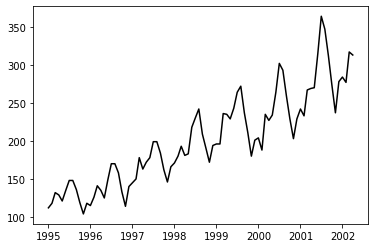

In [43]:
# Visualization of Forecasted values for Test data set using different methods 
plt.plot(Train.index, Train["Passengers"], label='Train',color="black")

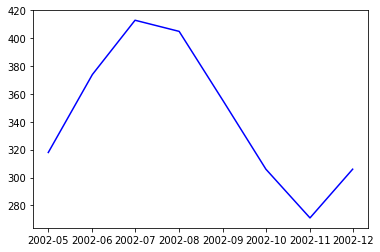

In [44]:
plt.plot(Test.index, Test["Passengers"], label='Test',color="blue")

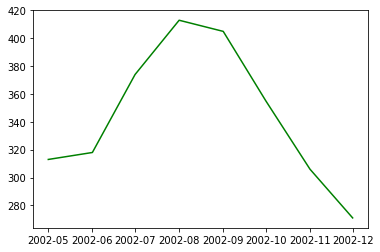

In [45]:
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")

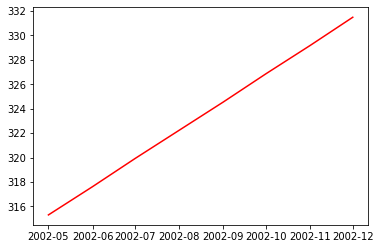

In [46]:
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")

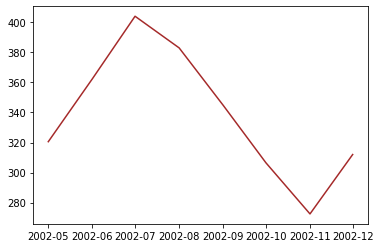

In [47]:
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")

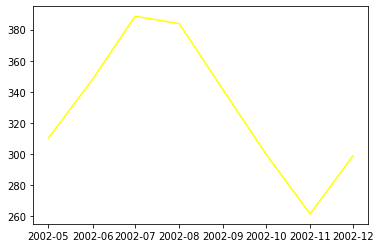

In [48]:
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")

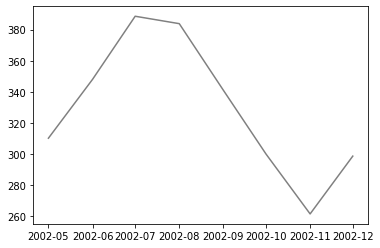

In [49]:
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="Auto_Arima",color="grey")

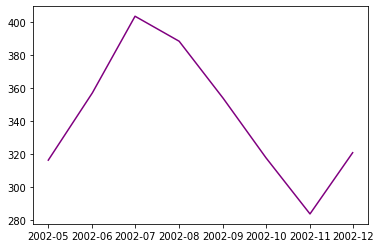

In [50]:
plt.plot(pred_hwe_mul_add.index,srma_pred,label="Auto_Sarima",color="purple")

No handles with labels found to put in legend.


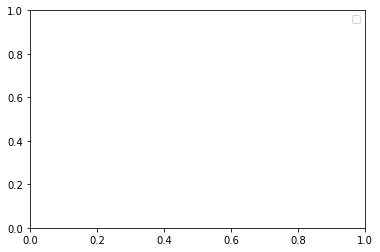

In [51]:
plt.legend(loc='best')

In [52]:
# Models and their MAPE values
model_mapes = pd.DataFrame(columns=["model_name","mape"])

In [53]:
model_mapes["model_name"] = [" "]
# Visualizing the ACF and PACF plots for errors 

In [54]:
model_mapes["model_name"] 

0     
Name: model_name, dtype: object

In [55]:
airlines=pd.read_csv("/content/Airlines+Data.csv")

In [56]:
month =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] 
import numpy as np

In [57]:
p = airlines["Month"][0]

In [58]:
p[0:3]

'Jan'

In [59]:
airlines['months']= 0

In [60]:
for i in range(96):
    p = airlines["Month"][i]
    airlines['months'][i]= p[0:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [61]:
month_dummies = pd.DataFrame(pd.get_dummies(airlines['months']))
airlines1 = pd.concat([airlines,month_dummies],axis = 1)


In [62]:
airlines1["t"] = np.arange(1,97)


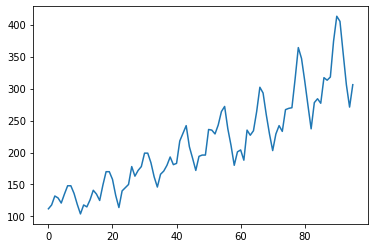

In [64]:
airlines1["t_squared"] = airlines1["t"]*airlines1["t"]
airlines1.columns
airlines1["log_Rider"] = np.log(airlines1["Passengers"])
#airlines1.rename(columns={"Ridership ": 'Ridership'}, inplace=True)
airlines1.Passengers.plot()
Train = airlines1.head(88)
Test = airlines1.tail(8)


In [65]:
####################### L I N E A R ##########################
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

63.372426393143506

In [66]:
##################### Exponential ##############################

Exp = smf.ols('log_Rider~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

55.51430684778264

In [67]:
#################### Quadratic ###############################

Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

58.30476227446945

In [68]:
################### Additive seasonality ########################

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

140.53630876621403

In [69]:
################## Additive Seasonality Quadratic ############################

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad 

31.609953160756397

In [70]:
################## Multiplicative Seasonality ##################

Mul_sea = smf.ols('log_Rider~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

148.45577274025467

In [71]:
##################Multiplicative Additive Seasonality ###########

Mul_Add_sea = smf.ols('log_Rider~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

12.288706584795992

In [72]:
################## Testing #######################################

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,63.372426
1,rmse_Exp,55.514307
2,rmse_Quad,58.304762
3,rmse_add_sea,140.536309
4,rmse_add_sea_quad,31.609953
5,rmse_Mult_sea,148.455773
6,rmse_Mult_add_sea,12.288707
